In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import time
import matplotlib.pyplot as plt
import pandas as pd

/usr/local/lib/python3.10/dist-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


## Hyperparameters and Configuration

In [2]:
# Modified hyperparameters
SEQUENCE_LENGTH = 256

EMBEDDING_DIM = SEQUENCE_LENGTH
HIDDEN_DIM = EMBEDDING_DIM

BATCH_SIZE = 512
EPOCHS = 15
LEARNING_RATE = 1e-4
VALIDATION_SPLIT = 0.1

NUM_LAYERS = 2
NUM_HEADS = 4
FFN_DIM = SEQUENCE_LENGTH
DROPOUT = 0.1

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda:0


## Data Preparation

We are using the TinyShakespeare dataset, a small character-level text corpus consisting of a subset of Shakespeare's plays. It's often used for testing sequence models, as it includes a rich set of vocabulary and provides a challenging task for next-character prediction.

In [3]:
## Utility Functions

def load_data(filename):
    with open(filename, 'r', encoding='utf-8') as f:
        return f.read()

def create_char_mappings(text):
    chars = sorted(list(set(text)))
    char_to_idx = {ch: i for i, ch in enumerate(chars)}
    idx_to_char = {i: ch for i, ch in enumerate(chars)}
    return chars, char_to_idx, idx_to_char

## Dataset

In [4]:
class CharDataset(Dataset):
    def __init__(self, text, seq_length, char_to_idx):
        self.text = text
        self.seq_length = seq_length
        self.char_to_idx = char_to_idx

    def __len__(self):
        return len(self.text) - self.seq_length

    def __getitem__(self, idx):
        x = [self.char_to_idx[ch] for ch in self.text[idx:idx+self.seq_length]]
        y = [self.char_to_idx[ch] for ch in self.text[idx+1:idx+self.seq_length+1]]
        return torch.tensor(x), torch.tensor(y)

In [5]:
def prepare_data(text, seq_length, batch_size, val_split):
    chars, char_to_idx, idx_to_char = create_char_mappings(text)

    # Split data into train and validation
    val_size = int(len(text) * val_split)
    train_text, val_text = text[:-val_size], text[-val_size:]

    train_dataset = CharDataset(train_text, seq_length, char_to_idx)
    val_dataset = CharDataset(val_text, seq_length, char_to_idx)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=12, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=12, pin_memory=True)

    return train_loader, val_loader, chars, char_to_idx, idx_to_char

In [6]:
# !wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=19zosLuU0z4MxIMKbGVYEGlg52QyfbTIy' -O input.txt

In [7]:
# Load the data
text = load_data('../data/input.txt')
train_loader, val_loader, chars, char_to_idx, idx_to_char = prepare_data(text, SEQUENCE_LENGTH, BATCH_SIZE, VALIDATION_SPLIT)
vocab_size = len(chars)

print(f"Total characters: {len(text)}")
print(f"Vocabulary size: {vocab_size}")
print(f"Train dataset size: {len(train_loader.dataset)}")
print(f"Validation dataset size: {len(val_loader.dataset)}")

Total characters: 1115394
Vocabulary size: 65
Train dataset size: 1003599
Validation dataset size: 111283


## Data Visualization

In [8]:
# Function to convert index sequence to character sequence
def indices_to_text(indices, idx_to_char):
    return ''.join([idx_to_char[idx.item()] for idx in indices])

# Get a batch of data
dataiter = iter(train_loader)
batch_x, batch_y = next(dataiter)

print(f"Input shape: {batch_x.shape}")
print(f"Target shape: {batch_y.shape}")

# Print a few samples from the batch
num_samples = 3
for i in range(num_samples):
    print(f"Sample {i+1}: ------------------------------" )
    print("Input sequence :", indices_to_text(batch_x[i], idx_to_char).replace('\n',''))
    print("Target sequence:", indices_to_text(batch_y[i], idx_to_char).replace('\n',''))
    print()


Input shape: torch.Size([512, 256])
Target shape: torch.Size([512, 256])
Sample 1: ------------------------------
Input sequence : wed, I'll pardon you:Graze where you will you shall not house with me:Look to't, think on't, I do not use to jest.Thursday is near; lay hand on heart, advise:An you be mine, I'll give you to my friend;And you be not, hang, beg, starve, die inthe stre
Target sequence: ed, I'll pardon you:Graze where you will you shall not house with me:Look to't, think on't, I do not use to jest.Thursday is near; lay hand on heart, advise:An you be mine, I'll give you to my friend;And you be not, hang, beg, starve, die inthe stree

Sample 2: ------------------------------
Input sequence : er many scorns, many foul taunts,They took his head, and on the gates of YorkThey set the same; and there it doth remain,The saddest spectacle that e'er I view'd.EDWARD:Sweet Duke of York, our prop to lean upon,Now thou art gone, we have no staff, n
Target sequence: r many scorns, many foul

## Training Function

In [9]:
def print_vram_usage(device="cuda"):
    allocated = torch.cuda.memory_allocated(device) / (1024**2)  # in MB
    reserved = torch.cuda.memory_reserved(device) / (1024**2)    # in MB
    max_allocated = torch.cuda.max_memory_allocated(device) / (1024**2)  # in MB
    print(f"Allocated: {allocated:.2f} MB, Reserved: {reserved:.2f} MB, Max Allocated: {max_allocated:.2f} MB")

In [10]:
def validate(model, dataloader, criterion, device, epoch, step):
    model.eval()
    losses = []
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            output, _ = model(x)
            loss = criterion(output.view(-1, output.size(-1)), y.view(-1))
            losses.append((step, epoch, loss.item()))
    return losses

In [11]:
from tqdm import tqdm

def train(model, dataloader, criterion, optimizer, device, epoch, step):
    model.train()
    losses = []
    vram_usage = []
    scaler = torch.amp.GradScaler('cuda')
    pbar = tqdm(dataloader, desc=f"Epoch {epoch}", leave=False)
    for batch, (x, y) in enumerate(pbar):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        
        with torch.amp.autocast('cuda'):
            output, _ = model(x)
            loss = criterion(output.view(-1, output.size(-1)), y.view(-1))
            
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        step += 1
        losses.append((step, epoch, loss.item()))
        
        # VRAM 사용량을 progress bar의 postfix로 업데이트
        allocated = torch.cuda.memory_allocated(device) / (1024**2)
        vram_usage.append(allocated)
        pbar.set_postfix(loss=f'{loss.item():.4f}', step=step, vram=f'{allocated:.2f} MB')
    return losses, step, vram_usage

## Generation Function

In [12]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs):
    all_train_losses = []
    all_val_losses = []
    all_vram_usages = []
    step = 0

    for epoch in range(1, epochs + 1):
        epoch_start_time = time.time()
        # Training phase with tqdm updates
        epoch_train_losses, step, vram_usage = train(model, train_loader, criterion, optimizer, device, epoch, step)
        all_train_losses.extend(epoch_train_losses)
        all_vram_usages.append(vram_usage)
        
        # Validation phase
        epoch_val_losses = validate(model, val_loader, criterion, device, epoch, step)
        all_val_losses.extend(epoch_val_losses)
        
        epoch_time = time.time() - epoch_start_time
        print(f'Epoch {epoch}/{epochs}, Train Loss: {epoch_train_losses[-1][2]:.4f}, '
              f'Val Loss: {epoch_val_losses[-1][2]:.4f}, Epoch Time: {epoch_time:.2f}s',
              f'Average Vram Usage: {np.mean(vram_usage):.2f}MB')

    train_losses_df = pd.DataFrame(all_train_losses, columns=['step', 'epoch', 'loss_value'])
    val_losses_df = pd.DataFrame(all_val_losses, columns=['step', 'epoch', 'loss_value'])
    # average_vram_usage = np.mean(all_vram_usages)
    return model, train_losses_df, val_losses_df


In [13]:
def generate_text(model, char_to_idx, idx_to_char, start_text, device, max_length=500):
    model.eval()
    current_text = start_text
    hidden = None

    with torch.no_grad():
        for _ in range(max_length):
            x = torch.tensor([[char_to_idx[ch] for ch in current_text[-SEQUENCE_LENGTH:]]]).to(device)
            output, hidden = model(x, hidden)
            probs = torch.softmax(output[0, -1], dim=0)
            next_char_idx = torch.multinomial(probs, 1).item()
            next_char = idx_to_char[next_char_idx]
            current_text += next_char

    return current_text

In [14]:
loss_comparison_dict = {}

def add_loss_to_comparison(model_name, train_losses_df, val_losses_df):
    """
    Adds training and validation losses from a model to the comparison dictionary.
    """
    loss_comparison_dict[model_name] = {
        'train': train_losses_df,
        'val': val_losses_df
    }

def print_final_losses(loss_dict):
    for model_name, losses in loss_dict.items():
        train_df = losses['train']
        val_df = losses['val']
        final_train = train_df.groupby('epoch')['loss_value'].last().iloc[-1]
        final_val = val_df.groupby('epoch')['loss_value'].last().iloc[-1]
        print(f"{model_name}: Final Train Loss: {final_train:.4f}, Final Val Loss: {final_val:.4f}")

In [15]:
# Function to plot loss curves
def plot_loss(train_losses_df, val_losses_df):
    plt.figure(figsize=(10, 5))

    # Plot training losses
    for epoch in train_losses_df['epoch'].unique():
        epoch_train_losses = train_losses_df[train_losses_df['epoch'] == epoch]
        plt.plot(epoch_train_losses['step'], epoch_train_losses['loss_value'],
                 color='blue', alpha=0.3)

    # scatter training loss at the end of each epoch
    last_train_losses = train_losses_df.groupby('epoch').last().reset_index()
    plt.scatter(last_train_losses['step'], last_train_losses['loss_value'],
                color='blue')

    # Plot and scatter validation loss at the end of each epoch
    last_val_losses = val_losses_df.groupby('epoch').last().reset_index()
    plt.plot(last_val_losses['step'], last_val_losses['loss_value'],
             color='orange', label='Validation Loss')
    plt.scatter(last_val_losses['step'], last_val_losses['loss_value'],
                color='orange')

    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Function to print final loss values
def print_final_losses(train_losses_df, val_losses_df):
    print("Final Training Loss:", train_losses_df.groupby('epoch')['loss_value'].last().iloc[-1])
    print("Final Validation Loss:", val_losses_df.groupby('epoch')['loss_value'].last().iloc[-1])

In [16]:
# Function to plot loss curves for multiple models stored in loss_comparison_dict
def plot_loss_comparisons():
    """
    Plots the training loss curves and average validation loss per epoch for multiple models added to the loss comparison dictionary.
    """
    plt.figure(figsize=(10, 5))
    
    # Get the last model in the dictionary (for special final-point highlighting)
    last_model_name = list(loss_comparison_dict.keys())[-1]

    # Loop through each model in the loss dictionary
    for model_name, losses in loss_comparison_dict.items():
        train_losses_df = losses['train']
        val_losses_df = losses['val']

        # Plot training losses for each model
        plt.plot(train_losses_df['step'], train_losses_df['loss_value'],
                 label=f'{model_name} train', linestyle='-', alpha=0.7)

        # Scatter training loss at the end of each epoch
        last_train_losses = train_losses_df.groupby('epoch').last().reset_index()
        plt.scatter(last_train_losses['step'], last_train_losses['loss_value'], marker='o', s=50)

        # Compute average validation loss per epoch (using the last step of each epoch for x-axis)
        avg_val_losses = val_losses_df.groupby('epoch').agg({'loss_value': 'mean', 'step': 'last'}).reset_index()
        # Scatter the average validation loss for each epoch
        plt.scatter(avg_val_losses['step'], avg_val_losses['loss_value'], marker='s', s=50,
                    label=f'{model_name} val avg')

        # For the last model, highlight the final training loss with a star
        if model_name == last_model_name:
            final_step = train_losses_df['step'].iloc[-1]
            final_loss = train_losses_df['loss_value'].iloc[-1]
            plt.scatter(final_step, final_loss, marker='*', s=100, color='red', zorder=5)

    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.title('Training Loss Comparison')
    plt.legend()  # Legend shows both training and validation average labels
    plt.grid(True)
    plt.show()


In [17]:
def plot_separate_train_val(loss_dict):
    """
    모델별 Training Loss와 Validation Loss를 각각 별도의 그래프로 그립니다.
    단, Validation Loss는 에포크별 평균으로 계산합니다.
    """
    # 1. Training Loss Plot (원본 그대로)
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 2, 1)  # 1행 2열 중 첫 번째
    for model_name, losses in loss_dict.items():
        train_df = losses['train']
        steps_train = train_df['step'].values
        loss_train = train_df['loss_value'].values
        plt.plot(steps_train, loss_train, label=f'{model_name} Train')
    plt.title('Training Loss Comparison')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # 2. Validation Loss Plot (에포크별 평균 처리)
    plt.subplot(1, 2, 2)  # 1행 2열 중 두 번째
    for model_name, losses in loss_dict.items():
        val_df = losses['val']
        # 에포크별 평균 loss와 마지막 step을 계산
        val_avg = val_df.groupby('epoch').agg({'loss_value': 'mean', 'step': 'last'}).reset_index()
        plt.plot(val_avg['step'], val_avg['loss_value'], label=f'{model_name} Val')
    plt.title('Validation Loss (Epoch Avg) Comparison')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


## Model 1: GRU Decoder

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GRUDecoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers=2, dropout=0.1):
        super(GRUDecoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers=num_layers,
                          dropout=dropout if num_layers > 1 else 0.0, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, vocab_size)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(hidden_dim)

    def forward(self, x, hidden=None):
        embed = self.embedding(x)
        output, hidden = self.gru(embed, hidden)
        output = self.dropout(output)
        output = self.layer_norm(output)
        output = F.gelu(self.fc1(output))
        output = self.fc2(output)
        return output, hidden

In [19]:
### Model Initialization
gru = GRUDecoder(vocab_size, EMBEDDING_DIM, HIDDEN_DIM, NUM_LAYERS).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(gru.parameters(), lr=LEARNING_RATE, fused=True)

In [20]:
from torchinfo import summary

summary(gru, input_size=(BATCH_SIZE, SEQUENCE_LENGTH), dtypes=[torch.long])

Layer (type:depth-idx)                   Output Shape              Param #
GRUDecoder                               [512, 256, 65]            --
├─Embedding: 1-1                         [512, 256, 256]           16,640
├─GRU: 1-2                               [512, 256, 256]           789,504
├─Dropout: 1-3                           [512, 256, 256]           --
├─LayerNorm: 1-4                         [512, 256, 256]           512
├─Linear: 1-5                            [512, 256, 256]           65,792
├─Linear: 1-6                            [512, 256, 65]            16,705
Total params: 889,153
Trainable params: 889,153
Non-trainable params: 0
Total mult-adds (G): 103.53
Input size (MB): 1.05
Forward/backward pass size (MB): 1141.90
Params size (MB): 3.56
Estimated Total Size (MB): 1146.50

In [ ]:
## Training Loop
trained_model, train_losses_df, val_losses_df = train_model(gru, train_loader, val_loader, criterion, optimizer, device, EPOCHS)

Epoch 1/15, Train Loss: 1.4164, Val Loss: 1.5818, Epoch Time: 63.39s Average Vram Usage: 54.67MB


In [ ]:
# Text generation using validation data
val_sample, _ = next(iter(val_loader))
start_text = ''.join([idx_to_char[idx.item()] for idx in val_sample[0][:SEQUENCE_LENGTH]])

In [ ]:
generated_text = generate_text(trained_model, char_to_idx, idx_to_char, start_text, device)
                      
print(f"Generated text (starting with validation data [{start_text}]):")
print("-"*50)
print(generated_text)

Generated text (starting with validation data [

GREMIO:
Good morrow, neighbour Baptista.

BAPTISTA:
Good morrow, neighbour Gremio.
God save you, gentlemen!

PETRUCHIO:
And yo]):
--------------------------------------------------


GREMIO:
Good morrow, neighbour Baptista.

BAPTISTA:
Good morrow, neighbour Gremio.
God save you, gentlemen!

PETRUCHIO:
And you!

DUKE VINCENTIO:
Help thee; let's make him not; for I have none
As from my profession that thou carries me
Till then with slamperors will complain awhile;
Of our departure, as he may do not impose;
Even like another subjects lunatic
Cry of my kindness; there be their absence
Did never hear to break, and do a deed I lay;
See where he best I might in this fear
To make me wish too sweet a witness and good
proclanet, to this reason shall from whence 'twixt Cason,
If he were letters of foes doth a


In [ ]:
# After training a model (e.g., LSTM without RMSNorm), add its losses
add_loss_to_comparison('GRU', train_losses_df, val_losses_df)

In [ ]:
# Decoder Input/Output Example
sample_input, _ = next(iter(val_loader))
sample_input = sample_input[0].unsqueeze(0).to(device)  # Add batch dimension

trained_model.eval()
with torch.no_grad():
    output, _ = trained_model(sample_input)

print("\nSample Input:")
print(''.join([idx_to_char[idx.item()] for idx in sample_input[0]]))

print("\nModel Output (logits for next character prediction):")
print(output.shape)
print(output[0, 0, :10])  # Print first 10 logits of the first timestep

print("\nPredicted next character:")
predicted_char_idx = torch.argmax(output[0, -1]).item()
print(idx_to_char[predicted_char_idx])


Sample Input:


GREMIO:
Good morrow, neighbour Baptista.

BAPTISTA:
Good morrow, neighbour Gremio.
God save you, gentlemen!

PETRUCHIO:
And yo

Model Output (logits for next character prediction):
torch.Size([1, 128, 65])
tensor([  3.9424,  -8.0234,  -9.1524, -20.0824, -19.3439,   0.2559, -10.6087,
        -11.7021, -10.6298,  -3.8925], device='cuda:0')

Predicted next character:
u


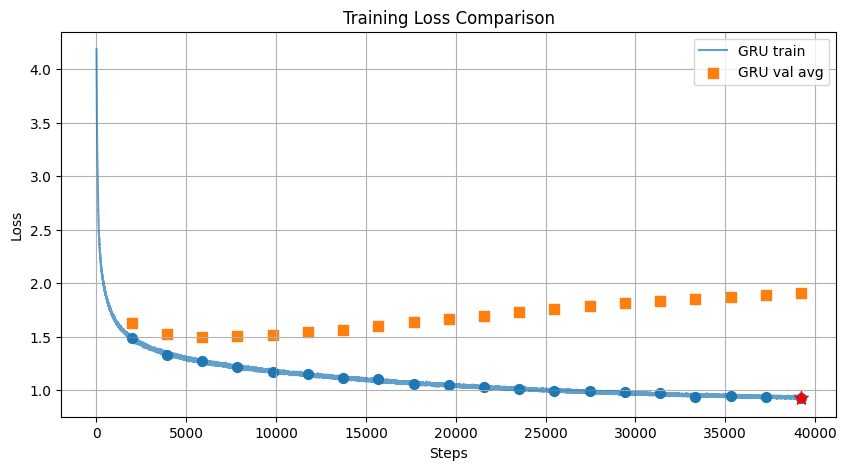

In [ ]:
plot_loss_comparisons()

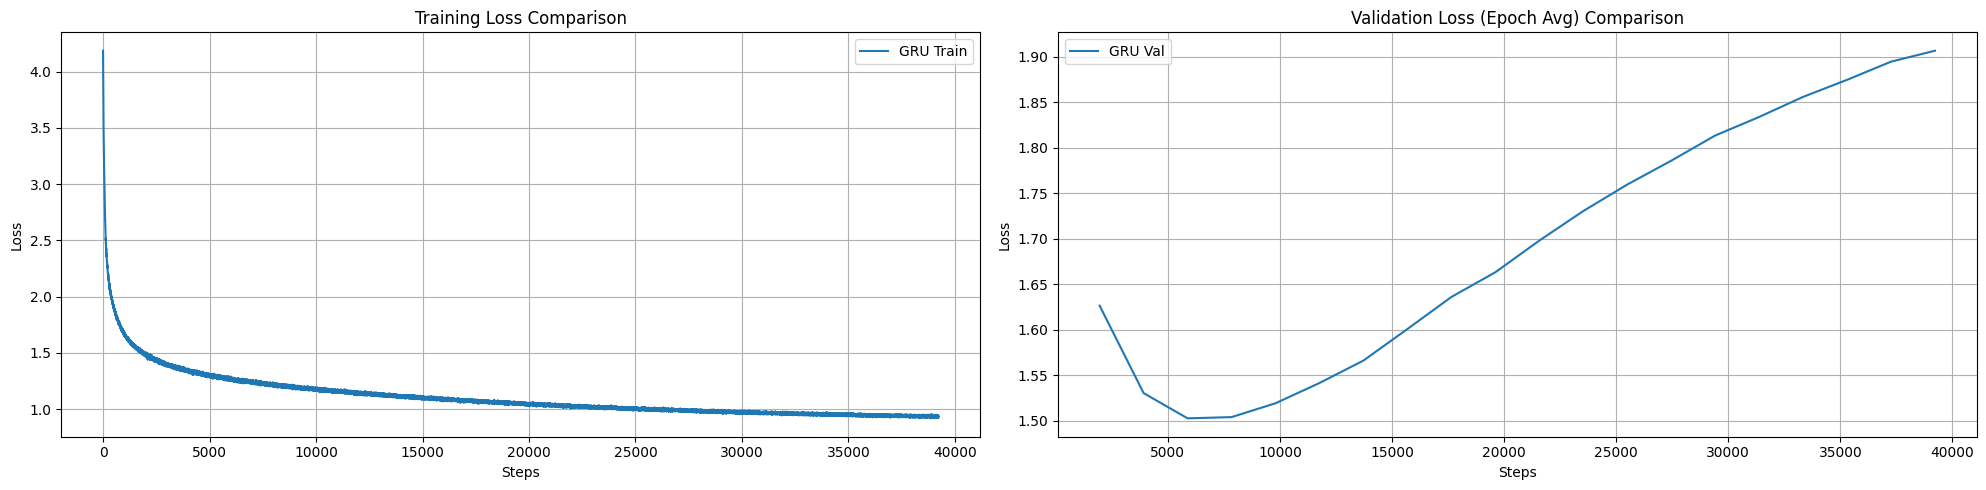

In [ ]:
plot_separate_train_val(loss_comparison_dict)

In [ ]:
def generate_text_attention(model, char_to_idx, idx_to_char, start_text, device, max_length=500):
    model.eval()
    current_text = start_text

    with torch.no_grad():
        for _ in range(max_length):
            # Convert the last sequence of characters to indices and feed it to the model
            x = torch.tensor([[char_to_idx[ch] for ch in current_text[-SEQUENCE_LENGTH:]]]).to(device)
            output = model(x)[0]  # No hidden state needed for attention-based models
            probs = torch.softmax(output[0, -1], dim=0)
            next_char_idx = torch.multinomial(probs, 1).item()
            next_char = idx_to_char[next_char_idx]
            current_text += next_char

    return current_text

In [ ]:
def train_and_test(model_desc, model, start_text):
    # Initialize the model
    model = model.to(device)
    # Use the same optimizer and criterion
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, fused=True)
    
    # Train the model
    trained_model, train_losses_df, val_losses_df = train_model(
        model, train_loader, val_loader, criterion, optimizer, device, EPOCHS
    )

    # Generate text
    generated_text = generate_text_attention(trained_model, char_to_idx, idx_to_char, start_text, device)
    print(f"Generated text [{start_text}]:")
    print("-"*50)
    print(generated_text)
    
    add_loss_to_comparison(model_desc, train_losses_df, val_losses_df)

    # Plot loss comparisons including this model
    plot_loss_comparisons()
    
    plot_separate_train_val(loss_comparison_dict)

## Model 2: Modern Transformer(LLaMA - 2023)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from dataclasses import dataclass

@dataclass
class ModelArgs:
    DIM = EMBEDDING_DIM 
    FFN_DIM = int(FFN_DIM * 4)
    NUM_HEADS = NUM_HEADS 
    NUM_LAYERS = NUM_LAYERS

    NUM_KV_HEADS = NUM_HEADS 
    VOCAB_SIZE = vocab_size
    NORM_EPS = 1e-5 # LLaMA: 1e-5
    ROPE_THETA = 10000 # LLaMA: 10000

    MAX_BATCH_SIZE = BATCH_SIZE
    MAX_SEQ_LEN = SEQUENCE_LENGTH # depending on the DATASET
    NUM_KV_HEAD_REP = NUM_HEADS // NUM_KV_HEADS

    HEAD_DIM = DIM // NUM_HEADS
    DROPOUT = DROPOUT
    DEVICE = device

class RMSNorm(nn.Module):
    def __init__(self, dim: int, eps: float = 1e-6):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(dim))
    def _norm(self, x: torch.Tensor):
        return x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps)
    def forward(self, x: torch.Tensor):
        return self.weight.to(x.device) * self._norm(x.float()).type_as(x)
    
def precompute_freqs_cis(head_dim: int, seq_len: int, theta: float = 100.0, device: str = "cuda:0"):
    if head_dim % 2 != 0:
        raise ValueError("head_dim must be even for rotary embeddings.")
    freqs = 1.0 / (theta ** (torch.arange(0, head_dim, 2).float() / head_dim)).to(device)
    t = torch.arange(seq_len, device=device, dtype=torch.float32)
    freqs = torch.outer(t, freqs)  # [seq_len, head_dim//2]
    freqs_cis = torch.polar(torch.ones_like(freqs), freqs)
    return freqs_cis  # [seq_len, head_dim // 2]

def reshape_for_broadcast(freqs_cis: torch.Tensor, x: torch.Tensor):
    L = x.shape[1]
    return freqs_cis.view(1, L, 1, x.shape[-1] // 2)  # [1, L, 1, head_dim]

def apply_rotary_emb(x: torch.Tensor, device: str = "cuda:0"):
    # x: [B, L, 2*heads, D] & D is even
    _, L, _, D = x.shape
    x_complex = torch.view_as_complex(x.float().reshape(*x.shape[:-1], -1, 2)) # [B, L, 2*heads, D//2, 2]
    freqs_cis = precompute_freqs_cis(D, L)
    freqs = reshape_for_broadcast(freqs_cis, x)
    x_rotated = x_complex * freqs
    x_out = torch.view_as_real(x_rotated).reshape(x.shape)
    return x_out.type_as(x).to(device)

def repeat_kv(x: torch.Tensor, n_rep: int) -> torch.Tensor:
    B, L, nk, d = x.shape
    if n_rep == 1:
        return x
    return x[:, :, :, None, :].expand(B, L, nk, n_rep, d).reshape(B, L, nk * n_rep, d)

class FeedForward(nn.Module):
    def __init__(self, dim, ffn_dim, dropout):
        super().__init__()
        hidden_dim = ffn_dim
        self.w1 = nn.Linear(dim, hidden_dim, bias=False)
        self.w2 = nn.Linear(hidden_dim, dim, bias=False)
        self.w3 = nn.Linear(dim, hidden_dim, bias=False)
        self.dropout = nn.Dropout(dropout)
    def forward(self, x: torch.Tensor):
        # x: [B, L, D]
        return self.w2(F.silu(self.w1(x)) * self.dropout(self.w3(x)))

class SelfAttention(nn.Module):
    def __init__(self, n_heads, n_kv_heads, n_rep, dim, dropout, batch, seq_len, device):
        super().__init__()
        self.n_heads_q = n_heads
        self.n_kv_heads = n_kv_heads
        self.n_rep = n_rep
        self.head_dim = dim // n_heads

        self.wq = nn.Linear(dim, n_heads * self.head_dim, bias=False)
        self.wk = nn.Linear(dim, n_kv_heads * self.head_dim, bias=False)
        self.wv = nn.Linear(dim, n_kv_heads * self.head_dim, bias=False)
        self.wo = nn.Linear(n_heads * self.head_dim, dim, bias=False)
        self.attn_dropout = dropout
        
        self.norm = RMSNorm(self.head_dim)

    def forward(self, x: torch.Tensor, start_pos, mask, return_attn=False):
        B, L, _ = x.shape
        src_len = trg_len = L
        offset = start_pos
        
        xq = self.wq(x).view(B, L, self.n_heads_q, self.head_dim)
        xk = self.wk(x).view(B, L, self.n_kv_heads, self.head_dim)
        xv = self.wv(x).view(B, L, self.n_kv_heads, self.head_dim)
        
        # Apply rotary embeddings
        xq = apply_rotary_emb(xq)
        xk = apply_rotary_emb(xk)
        
        # GQA: Adjust dimensions for attention computation
        xq = xq.transpose(1, 2)   # [B, n_heads, L, head_dim]
        xk = repeat_kv(xk, self.n_rep).transpose(1, 2) # [B, n_heads, L, head_dim]
        xv = repeat_kv(xv, self.n_rep).transpose(1, 2) # [B, n_heads, L, head_dim]

        # Compute scaled dot-product attention manually to capture attention weights
        scores = torch.matmul(xq, xk.transpose(-2, -1)) / math.sqrt(self.head_dim)  # [B, n_heads, L, L]
        scores = torch.nan_to_num(scores)
        if mask is None:
            mask = torch.triu(
                torch.zeros([L, L])
                .float()
                .fill_(float("-inf"))
                .type_as(attn_weights),
                1 + offset,
            )
            
        scores += mask
        attn_weights = torch.softmax(scores, dim=-1)
        attn_weights = F.dropout(attn_weights, self.attn_dropout, training=self.training)
        attn_output = torch.matmul(attn_weights, xv)  # [B, n_heads, L, head_dim]
        attn_output = self.norm(attn_output)
        
        # Reshape attention output and project
        attn_output = attn_output.transpose(1, 2).contiguous().view(B, L, -1)
        output = self.wo(attn_output)  # [B, L, D]
        if return_attn:
            return output, attn_weights
        else:
            return output

class TransformerBlock(nn.Module):
    def __init__(self, args: 'ModelArgs'):
        super().__init__()
        self.attention = SelfAttention(
            args.NUM_HEADS, 
            args.NUM_KV_HEADS, 
            args.NUM_KV_HEAD_REP, 
            args.DIM, 
            args.DROPOUT, 
            args.MAX_BATCH_SIZE, 
            args.MAX_SEQ_LEN, 
            args.DEVICE
        )
        self.ffn = FeedForward(args.DIM, args.FFN_DIM, args.DROPOUT)
        self.attention_norm = RMSNorm(args.DIM, args.NORM_EPS)
        self.ffn_norm = RMSNorm(args.DIM, args.NORM_EPS)
        self.res_dropout = nn.Dropout(args.DROPOUT)
        
    def forward(self, x: torch.Tensor, start_pos, mask, return_attn=False):
        if return_attn:
            attn_out, attn_map = self.attention(self.attention_norm(x), start_pos, mask, return_attn=True)
            h = x + self.res_dropout(attn_out)
            h = h + self.res_dropout(self.ffn(self.ffn_norm(h)))
            return h, attn_map
        else:
            h = x + self.res_dropout(self.attention(self.attention_norm(x), start_pos, mask))
            h = h + self.res_dropout(self.ffn(self.ffn_norm(h)))
            return h

class LlamaTransformer(nn.Module):
    def __init__(self, args: 'ModelArgs'):
        super().__init__()
        self.args = args
        self.tok_embeddings = nn.Embedding(args.VOCAB_SIZE, args.DIM)
        self.layers = nn.ModuleList([TransformerBlock(args) for _ in range(args.NUM_LAYERS)])
        self.norm = RMSNorm(args.DIM, args.NORM_EPS)
        self.output = nn.Linear(args.DIM, args.VOCAB_SIZE, bias=False)
        self.device = args.DEVICE
        
    def forward(self, x: torch.Tensor, start_pos=0, return_attn=False):
        B, L = x.shape
        h = self.tok_embeddings(x)  # [B, L, D]
        
        mask = None
        if L > 1:
            mask = torch.triu(
                torch.zeros([L, L])
                .float()
                .fill_(float("-inf"))
                .type_as(x),
                1 + start_pos,
            )
        attn_maps = []
        for layer in self.layers:
            if return_attn:
                h, attn_map = layer(h, start_pos, mask, return_attn=True)
                attn_maps.append(attn_map)
            else:
                h = layer(h, start_pos, mask)
        logits = self.output(self.norm(h)).float()
        if return_attn:
            return logits, attn_maps
        return logits, _

In [ ]:
PARAMS = ModelArgs()
llama = LlamaTransformer(PARAMS).to(device)
llama

LlamaTransformer(
  (tok_embeddings): Embedding(65, 128)
  (layers): ModuleList(
    (0-1): 2 x TransformerBlock(
      (attention): SelfAttention(
        (wq): Linear(in_features=128, out_features=128, bias=False)
        (wk): Linear(in_features=128, out_features=128, bias=False)
        (wv): Linear(in_features=128, out_features=128, bias=False)
        (wo): Linear(in_features=128, out_features=128, bias=False)
        (norm): RMSNorm()
      )
      (ffn): FeedForward(
        (w1): Linear(in_features=128, out_features=512, bias=False)
        (w2): Linear(in_features=512, out_features=128, bias=False)
        (w3): Linear(in_features=128, out_features=512, bias=False)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (attention_norm): RMSNorm()
      (ffn_norm): RMSNorm()
      (res_dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (norm): RMSNorm()
  (output): Linear(in_features=128, out_features=65, bias=False)
)

In [ ]:
summary(llama.to(device), input_size=(BATCH_SIZE, SEQUENCE_LENGTH), dtypes=[torch.long])

Layer (type:depth-idx)                   Output Shape              Param #
LlamaTransformer                         [512, 128, 65]            --
├─Embedding: 1-1                         [512, 128, 128]           8,320
├─ModuleList: 1-2                        --                        --
│    └─TransformerBlock: 2-1             [512, 128, 128]           --
│    │    └─RMSNorm: 3-1                 [512, 128, 128]           128
│    │    └─SelfAttention: 3-2           [512, 128, 128]           65,568
│    │    └─Dropout: 3-3                 [512, 128, 128]           --
│    │    └─RMSNorm: 3-4                 [512, 128, 128]           128
│    │    └─FeedForward: 3-5             [512, 128, 128]           196,608
│    │    └─Dropout: 3-6                 [512, 128, 128]           --
│    └─TransformerBlock: 2-2             [512, 128, 128]           --
│    │    └─RMSNorm: 3-7                 [512, 128, 128]           128
│    │    └─SelfAttention: 3-8           [512, 128, 128]           65,

Epoch 1/20, Train Loss: 1.6986, Val Loss: 1.7752, Epoch Time: 56.10s Average Vram Usage: 58.82MB


Epoch 2/20, Train Loss: 1.5393, Val Loss: 1.7291, Epoch Time: 56.41s Average Vram Usage: 58.82MB


Epoch 3/20, Train Loss: 1.4893, Val Loss: 1.7356, Epoch Time: 56.45s Average Vram Usage: 58.82MB


Epoch 4/20, Train Loss: 1.4449, Val Loss: 1.7077, Epoch Time: 56.74s Average Vram Usage: 58.82MB


Epoch 5/20, Train Loss: 1.4110, Val Loss: 1.6778, Epoch Time: 56.55s Average Vram Usage: 58.82MB


Epoch 6/20, Train Loss: 1.3897, Val Loss: 1.6561, Epoch Time: 56.61s Average Vram Usage: 58.82MB


Epoch 7/20, Train Loss: 1.3878, Val Loss: 1.6495, Epoch Time: 56.41s Average Vram Usage: 58.82MB


Epoch 8/20, Train Loss: 1.3911, Val Loss: 1.6475, Epoch Time: 56.40s Average Vram Usage: 58.82MB


Epoch 9/20, Train Loss: 1.3691, Val Loss: 1.6386, Epoch Time: 56.58s Average Vram Usage: 58.82MB


Epoch 10/20, Train Loss: 1.3613, Val Loss: 1.6386, Epoch Time: 56.67s Average Vram Usage: 58.82MB


Epoch 11/20, Train Loss: 1.3386, Val Loss: 1.6303, Epoch Time: 56.27s Average Vram Usage: 58.82MB


Epoch 12/20, Train Loss: 1.3365, Val Loss: 1.6317, Epoch Time: 56.52s Average Vram Usage: 58.82MB


Epoch 13/20, Train Loss: 1.3320, Val Loss: 1.6154, Epoch Time: 56.56s Average Vram Usage: 58.82MB


Epoch 14/20, Train Loss: 1.3398, Val Loss: 1.6158, Epoch Time: 56.65s Average Vram Usage: 58.82MB


Epoch 15/20, Train Loss: 1.3210, Val Loss: 1.6188, Epoch Time: 56.50s Average Vram Usage: 58.82MB


Epoch 16/20, Train Loss: 1.3348, Val Loss: 1.6121, Epoch Time: 56.51s Average Vram Usage: 58.82MB


Epoch 17/20, Train Loss: 1.3089, Val Loss: 1.6046, Epoch Time: 56.52s Average Vram Usage: 58.82MB


Epoch 18/20, Train Loss: 1.3186, Val Loss: 1.6148, Epoch Time: 56.21s Average Vram Usage: 58.82MB


Epoch 19/20, Train Loss: 1.3023, Val Loss: 1.6134, Epoch Time: 56.24s Average Vram Usage: 58.82MB


Epoch 20/20, Train Loss: 1.2967, Val Loss: 1.6227, Epoch Time: 56.41s Average Vram Usage: 58.82MB
Generated text [

GREMIO:
Good morrow, neighbour Baptista.

BAPTISTA:
Good morrow, neighbour Gremio.
God save you, gentlemen!

PETRUCHIO:
And yo]:
--------------------------------------------------


GREMIO:
Good morrow, neighbour Baptista.

BAPTISTA:
Good morrow, neighbour Gremio.
God save you, gentlemen!

PETRUCHIO:
And you not to carquit be thus,
Which we promised in the chair after power
Is grace a long. This house are earth shall enter
it to this emmority, I had though it and dream'd
continue: I do not the tender of the earth
Is : now bequite of not, and do.

CLARENCE:
What's to-morrow with my tenderness a borrow,
And bloody breaks my unknowned with his pale.

LEONTES:
Nay, sir, do you well.

AUTOLYCUS:
Thank you noble reason what sours a employ to to me.

ANGELO:
He was he wanton with me: and cry them Edward 


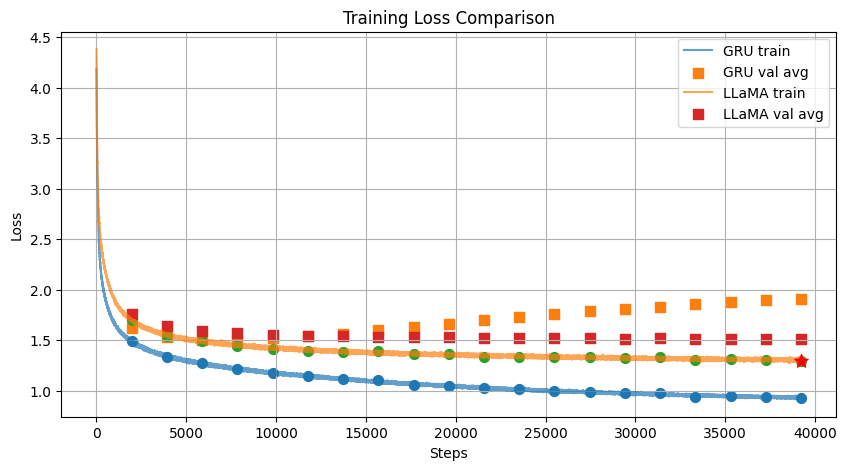

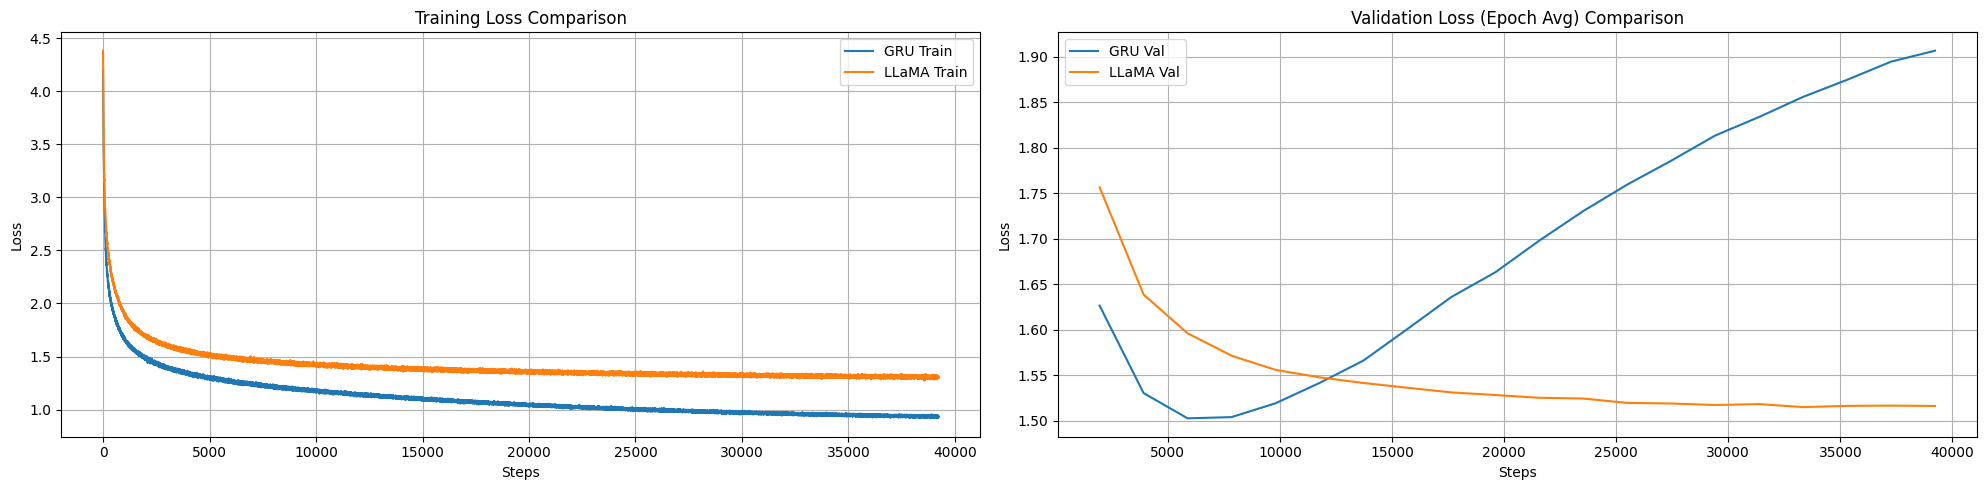

In [ ]:
train_and_test("LLaMA", llama, start_text)

## Model 3: Mamba

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange
import math # For initialization if needed

# --- Assume mamba_ssm is installed ---
# pip install mamba-ssm causal-conv1d
try:
    from causal_conv1d import causal_conv1d_fn, causal_conv1d_update # Need both for training/inference
    # causal_conv1d_fn is the main function for training/full sequence processing
except ImportError:
    print("Warning: 'causal_conv1d' package not found. Falling back to nn.Conv1d simulation.")
    print("Install with: pip install causal-conv1d")
    causal_conv1d_fn = None # Placeholder

try:
    from mamba_ssm.ops.selective_scan_interface import selective_scan_fn, mamba_inner_fn
    # selective_scan_fn wraps the CUDA/Triton kernel
except ImportError:
    print("Warning: 'mamba_ssm' package not found or compiled kernels unavailable.")
    print("SSM scan will use the less efficient PyTorch implementation.")
    print("Install with: pip install mamba-ssm")
    selective_scan_fn = None # Placeholder

[2025-05-26 05:36:57,122] [INFO] [real_accelerator.py:219:get_accelerator] Setting ds_accelerator to cuda (auto detect)


2025-05-26 05:36:58.785612: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-26 05:36:59.619653: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange, repeat
import math
from causal_conv1d import causal_conv1d_fn
from mamba_ssm.ops.selective_scan_interface import selective_scan_fn

# --- RMSNorm (Root Mean Square Layer Normalization) ---
class RMSNorm(nn.Module):
    """RMS 정규화 레이어.

    Args:
        dim (int): 정규화할 벡터의 차원.
        eps (float, optional): 분모에 더할 작은 값 (0으로 나누는 것 방지). 기본값: 1e-6.
    """
    def __init__(self, dim: int, eps: float = 1e-6):
        super().__init__()
        self.eps = eps
        # 학습 가능한 스케일링 파라미터 (gamma)
        self.weight = nn.Parameter(torch.ones(dim))

    def _norm(self, x: torch.Tensor) -> torch.Tensor:
        """RMS 정규화 계산 수행."""
        # 계산 안정성을 위해 float32 사용 후 원본 타입 복원
        original_dtype = x.dtype
        # 입력의 제곱 평균의 제곱근 역수 계산
        rms = torch.rsqrt(x.to(torch.float32).pow(2).mean(-1, keepdim=True) + self.eps)
        return (x * rms).to(original_dtype)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """RMS 정규화 적용."""
        # 정규화 후 학습 가능한 가중치 적용
        return self.weight * self._norm(x)

# --- SSM (State Space Model) 모듈 ---
class SSM(nn.Module):
    """선택적 스캔 메커니즘 (SSM). 최적화된 selective_scan_fn 커널 사용.
       Mamba v1 논문의 파라미터화 및 계산 방식 (non-fused path) 기반.
       selective_scan_fn이 기대하는 특정 텐서 레이아웃(B,D,L / B,N,L 등)을 따름.

    Args:
        d_inner (int): 내부 확장 차원 (D).
        state_size (int): SSM 상태 벡터 크기 (N).
        dt_rank (str or int, optional): Δ 계산 시 사용될 중간 랭크. "auto"시 d_inner / 16. 기본값: "auto".
        dt_min (float, optional): Δ의 최소값 제한 (softplus 적용 후). 기본값: 0.001.
        dt_max (float, optional): Δ의 최대값 제한 (softplus 적용 후). 기본값: 0.1.
        dt_init (str, optional): dt_proj 가중치 초기화 방식 ("random" or "constant"). 기본값: "random".
        dt_scale (float, optional): dt_proj 가중치 초기화 스케일. 기본값: 1.0.
        dt_init_floor (float, optional): dt 초기값 하한선. 기본값: 1e-4.
        bias (bool, optional): x_proj 레이어에 bias 사용 여부. 기본값: False.
        device (str, optional): 연산 장치. 기본값: 'cuda'.
        dtype (torch.dtype, optional): 연산 데이터 타입. 기본값: torch.float32.
    """
    def __init__(self, d_inner: int, state_size: int, dt_rank: str | int ="auto", dt_min: float =0.001, dt_max: float =0.1,
                 dt_init: str ="random", dt_scale: float =1.0, dt_init_floor: float =1e-4, bias: bool =False,
                 device: str ='cuda', dtype: torch.dtype =torch.float32):
        factory_kwargs = {"device": device, "dtype": dtype}
        super().__init__()
        self.d_inner = d_inner
        self.state_size = state_size
        # dt_rank 자동 계산 또는 지정값 사용
        self.dt_rank = math.ceil(d_inner / 16) if dt_rank == "auto" else dt_rank
        self.device = device
        self.dtype = dtype

        # 컨볼루션 출력(x)을 받아 dt_inter, B, C 계산용 프로젝션 (Mamba v1 non-fused 방식)
        self.x_proj = nn.Linear(self.d_inner, self.dt_rank + self.state_size * 2, bias=bias, **factory_kwargs)

        # dt_inter를 받아 dt 계산용 프로젝션
        self.dt_proj = nn.Linear(self.dt_rank, self.d_inner, bias=True, **factory_kwargs)

        # --- dt_proj bias 특별 초기화 (Mamba v1 공식 코드 참조) ---
        # 초기화 시 softplus(bias) 결과가 [dt_min, dt_max] 범위에 있도록 조정
        dt_init_std = self.dt_rank**-0.5 * dt_scale
        if dt_init == "constant":
            nn.init.constant_(self.dt_proj.weight, dt_init_std)
        elif dt_init == "random":
            nn.init.uniform_(self.dt_proj.weight, -dt_init_std, dt_init_std)
        else:
            raise NotImplementedError(f"Invalid dt_init: {dt_init}")

        # dt bias 초기값 계산 (softplus의 역함수 활용)
        dt = torch.exp(
            torch.rand(self.d_inner, **factory_kwargs) * (math.log(dt_max) - math.log(dt_min))
            + math.log(dt_min)
        ).clamp(min=dt_init_floor)
        inv_dt = dt + torch.log(-torch.expm1(-dt)) # softplus(inv_dt) ≈ dt
        with torch.no_grad():
            self.dt_proj.bias.copy_(inv_dt)
        # 다른 초기화 루틴에서 이 bias를 덮어쓰지 않도록 플래그 설정 (선택적)
        self.dt_proj.bias._no_reinit = True
        # --- dt_proj bias 초기화 종료 ---

        # --- SSM 파라미터 A (A_log) ---
        # S4D-Real 방식 초기화: A 행렬의 대각 요소가 [1, 2, ..., N]이 되도록 A_log 설정
        A = repeat(
            torch.arange(1, self.state_size + 1, dtype=torch.float32, device=device),
            "n -> d n", # 1차원 벡터를 d_inner 번 반복하여 (D, N) 행렬 생성
            d=self.d_inner,
        ).contiguous()
        A_log = torch.log(A) # 로그 스케일에서 파라미터 학습 (float32 유지)
        self.A_log = nn.Parameter(A_log)
        self.A_log._no_weight_decay = True # 가중치 감쇠 제외

        # --- SSM 파라미터 D (피드스루) ---
        # 형태: (D)
        self.D = nn.Parameter(torch.ones(self.d_inner, device=device)) # float32 유지 권장
        self.D._no_weight_decay = True # 가중치 감쇠 제외

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """SSM 순방향 계산. 입력 x는 (B, D, L) 레이아웃을 가정."""
        B, D, L = x.shape # 입력 레이아웃 확인
        if D != self.d_inner:
            raise ValueError(f"입력 차원 D({D})가 SSM 내부 차원({self.d_inner})과 불일치")

        # 1. 입력 x(컨볼루션 출력)로부터 dt, B, C 계산
        #    선형 프로젝션을 위해 (B*L, D) 형태로 변환
        x_reshaped = rearrange(x, "b d l -> (b l) d")
        x_proj_out = self.x_proj(x_reshaped) # 결과: (B*L, dt_rank + 2*N)
        dt_inter, B, C = torch.split(x_proj_out, [self.dt_rank, self.state_size, self.state_size], dim=-1)

        # 2. dt 계산 (softplus 적용 전) -> 형태 (B, D, L)
        #    dt_inter: (B*L, dt_rank)
        #    Mamba v1 non-fused path 방식 적용
        dt = self.dt_proj.weight @ dt_inter.t() # 결과: (D, B*L)
        dt = rearrange(dt, "d (b l) -> b d l", l=L) # 최종 형태: (B, D, L)
        # dt_bias는 selective_scan_fn 내부에서 delta_bias 인자로 전달되어 더해짐

        # 3. A 행렬 계산, 형태 (D, N)
        A = -torch.exp(self.A_log.float()) # float32에서 exp 계산

        # 4. B, C 형태 변경 -> (B, N, L)
        #    selective_scan_fn 커널이 요구하는 레이아웃
        B = rearrange(B, "(b l) n -> b n l", l=L).contiguous()
        C = rearrange(C, "(b l) n -> b n l", l=L).contiguous()

        # 5. D 파라미터 준비, 형태 (D)
        D_param = self.D.float().contiguous()

        # 6. selective_scan_fn 입력 준비 (메모리 연속성 보장)
        input_u = x.contiguous()             # u (SSM 입력): (B, D, L)
        input_delta = dt.contiguous()        # delta (dt): (B, D, L)
        input_A = A.contiguous()             # A: (D, N)
        input_B = B                          # B: (B, N, L)
        input_C = C                          # C: (B, N, L)
        input_D = D_param                    # D: (D)
        input_delta_bias = self.dt_proj.bias.float().contiguous() if self.dt_proj.bias is not None else None

        # 7. 최적화된 selective_scan_fn 호출
        #    입력 레이아웃 및 파라미터 형태는 Mamba v1 non-fused path 기준
        y = selective_scan_fn(
            u=input_u,
            delta=input_delta,
            A=input_A,
            B=input_B,
            C=input_C,
            D=input_D,
            z=None, # 게이트 z는 MambaBlock 레벨에서 처리
            delta_bias=input_delta_bias, # dt_bias 전달
            delta_softplus=True, # 내부에서 delta = softplus(dt + delta_bias) 계산
        )

        # 8. 결과 반환, 형태 (B, D, L)
        #    후속 처리를 위해 이 레이아웃 유지
        return y


# --- Mamba 블록 (causal_conv1d_fn 사용 및 데이터 흐름 수정) ---
class MambaBlock(nn.Module):
    """Mamba 핵심 블록. RMSNorm, 입력 프로젝션, 인과적 컨볼루션, SSM, 게이팅, 출력 프로젝션 구성.
       내부적으로 (B, D, L) 텐서 레이아웃 사용.
    """
    def __init__(self, d_model: int, state_size: int, d_conv: int = 4, expand: int = 1,
                 dropout_prob: float = 0.1, device: str = 'cuda', dtype: torch.dtype = torch.float32):
        factory_kwargs = {"device": device, "dtype": dtype}
        super().__init__()
        self.d_model = d_model
        self.d_inner = int(expand * d_model) # 내부 확장 차원 (D)
        self.state_size = state_size
        self.d_conv = d_conv
        self.device = device
        self.dtype = dtype

        # 입력 정규화 (RMSNorm)
        self.norm = RMSNorm(d_model, eps=1e-5)

        # 입력 프로젝션 (d_model -> 2 * d_inner)
        self.in_proj = nn.Linear(d_model, 2 * self.d_inner, bias=False, **factory_kwargs)

        # 인과적 컨볼루션 파라미터 (가중치 형태: D, K)
        self.conv1d_weight = nn.Parameter(torch.empty(self.d_inner, d_conv, **factory_kwargs))
        self.conv1d_bias = nn.Parameter(torch.empty(self.d_inner, **factory_kwargs))

        # SSM 모듈 인스턴스화 (Mamba v1 파라미터 전달 옵션 추가 가능)
        self.ssm = SSM(self.d_inner, state_size, device=device, dtype=dtype)
                      # dt_rank, dt_min 등 SSM 파라미터 전달 가능

        # 출력 프로젝션 (d_inner -> d_model)
        self.out_proj = nn.Linear(self.d_inner, d_model, bias=False, **factory_kwargs)

        # 잔차 연결 드롭아웃
        self.dropout_res = nn.Dropout(dropout_prob)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Mamba 블록 순방향 계산."""
        B, L, D_model = x.shape # 입력 형태: (B, L, d_model)
        residual = x # 잔차 연결용 원본 저장

        # 1. 입력 정규화
        x_norm = self.norm(x)

        # 2. 입력 프로젝션 및 분할 (x_in, z)
        xz = self.in_proj(x_norm) # 결과: (B, L, 2*D)
        x_in, z = xz.chunk(2, dim=-1) # 각각: (B, L, D)

        # 3. 인과적 컨볼루션 브랜치
        #    입력 레이아웃 변경: (B, L, D) -> (B, D, L)
        x_conv_in = rearrange(x_in, 'b l d -> b d l').contiguous()
        #    최적화된 causal_conv1d_fn 호출 (SiLU 활성화 포함)
        #    출력 x_conv_out 형태: (B, D, L)
        x_conv_out = causal_conv1d_fn(
            x=x_conv_in, weight=self.conv1d_weight, bias=self.conv1d_bias, activation='silu'
        )

        # 4. SSM 브랜치
        #    컨볼루션 출력(B, D, L)을 SSM에 직접 전달
        #    SSM 출력 y_ssm 형태: (B, D, L)
        y_ssm = self.ssm(x_conv_out)

        # 5. 게이팅 메커니즘
        #    y_ssm을 z와 곱하기 위해 (B, L, D) 형태로 변경
        y_ssm_rearranged = rearrange(y_ssm, 'b d l -> b l d')
        #    z에 SiLU 활성화 적용 후 요소별 곱셈
        y_gated = y_ssm_rearranged * F.silu(z) # 결과: (B, L, D)

        # 6. 출력 프로젝션
        output = self.out_proj(y_gated) # 결과: (B, L, d_model)

        # 7. 잔차 연결 및 드롭아웃
        output = residual + self.dropout_res(output) # 최종 결과: (B, L, d_model)

        return output

# --- Mamba 모델 전체 ---
class Mamba(nn.Module):
    """Mamba 언어 모델 전체 구조."""
    def __init__(self, d_model: int, n_layers: int, vocab_size: int, state_size: int = 16,
                 d_conv: int = 4, expand: int = 2, dropout_prob: float = 0.1,
                 device: str = 'cuda', dtype: torch.dtype = torch.float32):
        factory_kwargs = {"device": device, "dtype": dtype}
        super().__init__()
        self.d_model = d_model
        self.n_layers = n_layers
        self.vocab_size = vocab_size
        # 저장된 파라미터는 validation 등에 사용될 수 있음
        self.state_size = state_size
        self.d_conv = d_conv
        self.expand = expand
        self.dropout_prob = dropout_prob
        self.device = device
        self.dtype = dtype

        # 토큰 임베딩 레이어
        self.embedding = nn.Embedding(vocab_size, d_model, **factory_kwargs)
        self.dropout_emb = nn.Dropout(dropout_prob)

        # Mamba 블록 스택
        self.layers = nn.ModuleList([
            MambaBlock(
                d_model=d_model, state_size=state_size, d_conv=d_conv,
                expand=expand, dropout_prob=dropout_prob, device=device, dtype=dtype
            ) for _ in range(n_layers)
        ])

        # 최종 정규화 레이어
        self.norm_f = RMSNorm(d_model, eps=1e-5)
        # 언어 모델링 헤드 (출력 레이어)
        self.lm_head = nn.Linear(d_model, vocab_size, bias=False, **factory_kwargs)

        # 가중치 공유 (임베딩과 LM 헤드)
        self.lm_head.weight = self.embedding.weight

        # 모델 가중치 초기화 적용
        self.apply(self._init_weights)
        print(f"Mamba 모델 초기화 완료. Device: {device}, Dtype: {dtype}")

    def _init_weights(self, module):
        """모델의 각 모듈 가중치 초기화."""
        if isinstance(module, nn.Linear):
            # dt_proj의 bias는 특별 초기화되므로 건너뜀
            if hasattr(module.bias, '_no_reinit') and module.bias._no_reinit:
                return
            # Linear 레이어 가중치 초기화 (예: GPT-2 스타일)
            std = 0.02
            # 모델 깊이에 따른 스케일링 (옵션)
            if self.n_layers > 0:
                 # 입력/출력 프로젝션 등 특정 레이어에만 적용 고려 가능
                 if module.weight.shape[0] == self.d_model or module.weight.shape[1] == self.d_model:
                     std /= math.sqrt(2.0 * self.n_layers)
            nn.init.normal_(module.weight, mean=0.0, std=std)
            if module.bias is not None:
                nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            # 임베딩 가중치 초기화
            nn.init.normal_(module.weight, mean=0.0, std=0.02)
        elif isinstance(module, MambaBlock):
            # MambaBlock 내의 Conv1d 가중치 초기화
            if hasattr(module, 'conv1d_weight'):
                # Kaiming 초기화 (SiLU 활성화 함수에 적합)
                nn.init.kaiming_normal_(module.conv1d_weight, nonlinearity='leaky_relu')
            if hasattr(module, 'conv1d_bias'):
                nn.init.zeros_(module.conv1d_bias)
        # RMSNorm 가중치는 해당 클래스 생성자에서 1로 초기화됨
        # SSM 파라미터 (A_log, D)는 해당 클래스 생성자에서 초기화됨

    def forward(self, input_ids: torch.Tensor) -> tuple[torch.Tensor, None]:
        """Mamba 모델 순방향 계산."""
        B, L = input_ids.shape

        # 1. 임베딩 및 드롭아웃
        # 임베딩 레이어는 LongTensor 입력 필요
        x = self.embedding(input_ids.long())
        x = self.dropout_emb(x)

        # 2. Mamba 블록 순차 적용
        for layer in self.layers:
            x = layer(x)

        # 3. 최종 정규화
        x = self.norm_f(x)

        # 4. LM 헤드를 통해 로짓 계산
        logits = self.lm_head(x) # 결과: [B, L, vocab_size]

        # Loss 계산은 외부 학습 루프에서 처리 (labels 사용)
        # 여기서는 로짓과 None 반환 (일반적인 Hugging Face 모델 스타일)
        return logits, None

In [ ]:
'''
- pip install causal-conv1d
- mamba github clone > setup.py build > setup.py install
- sudo apt-get update && sudo apt-get install -y libaio-dev
'''

'\n- pip install causal-conv1d\n- mamba github clone > setup.py build > setup.py install\n- sudo apt-get update && sudo apt-get install -y libaio-dev\n'

In [ ]:
STATE_SIZE = 8

x = torch.randint(0, vocab_size, (BATCH_SIZE, SEQUENCE_LENGTH)).to(device)

mamba = Mamba(HIDDEN_DIM, NUM_LAYERS, vocab_size, STATE_SIZE, d_conv=4, expand=1.5).to(device)

test_output, _ = mamba(x)
print(f"test_output.shape = {test_output.shape}") 

Mamba 모델 초기화 완료. Device: cuda, Dtype: torch.float32
test_output.shape = torch.Size([512, 128, 65])


In [ ]:
from torchinfo import summary

summary(mamba.to(device), input_size=(BATCH_SIZE, SEQUENCE_LENGTH), dtypes=[torch.long])

Layer (type:depth-idx)                   Output Shape              Param #
Mamba                                    [512, 128, 65]            --
├─Embedding: 1-1                         [512, 128, 256]           16,640
├─Dropout: 1-2                           [512, 128, 256]           --
├─ModuleList: 1-3                        --                        --
│    └─MambaBlock: 2-1                   [512, 128, 256]           1,920
│    │    └─RMSNorm: 3-1                 [512, 128, 256]           256
│    │    └─Linear: 3-2                  [512, 128, 768]           196,608
│    │    └─SSM: 3-3                     [512, 384, 128]           28,416
│    │    └─Linear: 3-4                  [512, 128, 256]           98,304
│    │    └─Dropout: 3-5                 [512, 128, 256]           --
│    └─MambaBlock: 2-2                   [512, 128, 256]           1,920
│    │    └─RMSNorm: 3-6                 [512, 128, 256]           256
│    │    └─Linear: 3-7                  [512, 128, 768]    

Epoch 1/20, Train Loss: 1.3375, Val Loss: 1.6454, Epoch Time: 57.07s Average Vram Usage: 2478.94MB


Epoch 2/20, Train Loss: 1.2400, Val Loss: 1.6073, Epoch Time: 57.34s Average Vram Usage: 2478.94MB


Epoch 3/20, Train Loss: 1.2177, Val Loss: 1.6224, Epoch Time: 57.17s Average Vram Usage: 2478.94MB


Epoch 4/20, Train Loss: 1.1878, Val Loss: 1.6666, Epoch Time: 57.57s Average Vram Usage: 2478.94MB


Epoch 5/20, Train Loss: 1.1566, Val Loss: 1.6842, Epoch Time: 57.43s Average Vram Usage: 2478.94MB


Epoch 6/20, Train Loss: 1.1490, Val Loss: 1.7067, Epoch Time: 57.36s Average Vram Usage: 2478.94MB


Epoch 7/20, Train Loss: 1.1536, Val Loss: 1.7389, Epoch Time: 57.17s Average Vram Usage: 2478.94MB


Epoch 8/20, Train Loss: 1.1364, Val Loss: 1.7388, Epoch Time: 57.43s Average Vram Usage: 2478.94MB


Epoch 9/20, Train Loss: 1.1284, Val Loss: 1.7496, Epoch Time: 57.25s Average Vram Usage: 2478.94MB


Epoch 10/20, Train Loss: 1.1268, Val Loss: 1.7558, Epoch Time: 57.38s Average Vram Usage: 2478.94MB


Epoch 11/20, Train Loss: 1.1226, Val Loss: 1.7723, Epoch Time: 57.26s Average Vram Usage: 2478.94MB


Epoch 12/20, Train Loss: 1.1139, Val Loss: 1.7663, Epoch Time: 57.29s Average Vram Usage: 2478.94MB


Epoch 13/20, Train Loss: 1.0925, Val Loss: 1.7669, Epoch Time: 57.24s Average Vram Usage: 2478.94MB


Epoch 14/20, Train Loss: 1.1010, Val Loss: 1.7760, Epoch Time: 57.31s Average Vram Usage: 2478.94MB


Epoch 15/20, Train Loss: 1.0982, Val Loss: 1.7929, Epoch Time: 57.18s Average Vram Usage: 2478.94MB


Epoch 16/20, Train Loss: 1.0913, Val Loss: 1.8263, Epoch Time: 57.37s Average Vram Usage: 2478.94MB


Epoch 17/20, Train Loss: 1.0849, Val Loss: 1.8235, Epoch Time: 57.40s Average Vram Usage: 2478.94MB


Epoch 18/20, Train Loss: 1.0888, Val Loss: 1.8505, Epoch Time: 57.33s Average Vram Usage: 2478.94MB


Epoch 19/20, Train Loss: 1.0718, Val Loss: 1.8705, Epoch Time: 57.49s Average Vram Usage: 2478.94MB


Epoch 20/20, Train Loss: 1.0535, Val Loss: 1.8854, Epoch Time: 57.14s Average Vram Usage: 2478.94MB
Generated text [

GREMIO:
Good morrow, neighbour Baptista.

BAPTISTA:
Good morrow, neighbour Gremio.
God save you, gentlemen!

PETRUCHIO:
And yo]:
--------------------------------------------------


GREMIO:
Good morrow, neighbour Baptista.

BAPTISTA:
Good morrow, neighbour Gremio.
God save you, gentlemen!

PETRUCHIO:
And you excuse the means, thy state a discourse,
Have set to brooch a woeful mean so shall ask
Wickes a lack, and to carried the bound of blood,
Than for it is meditation, that e'er we than,
No redrelernity, for this will be enterance
And say 'Ay moving tempied much.

HENRY BOLINGBROKE:
What is the matter?

Nobly:
I am gone of your life should be your foe:
And yet, my lord, you shall know you say.

KING HENRY VI:
An ease, no more.

BRUTUS:
What is your spicio?

SICINIUS:
From which amain good days you


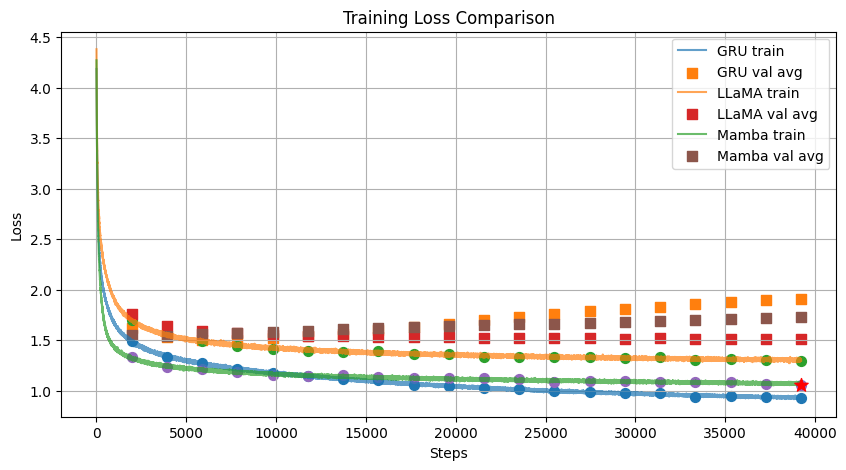

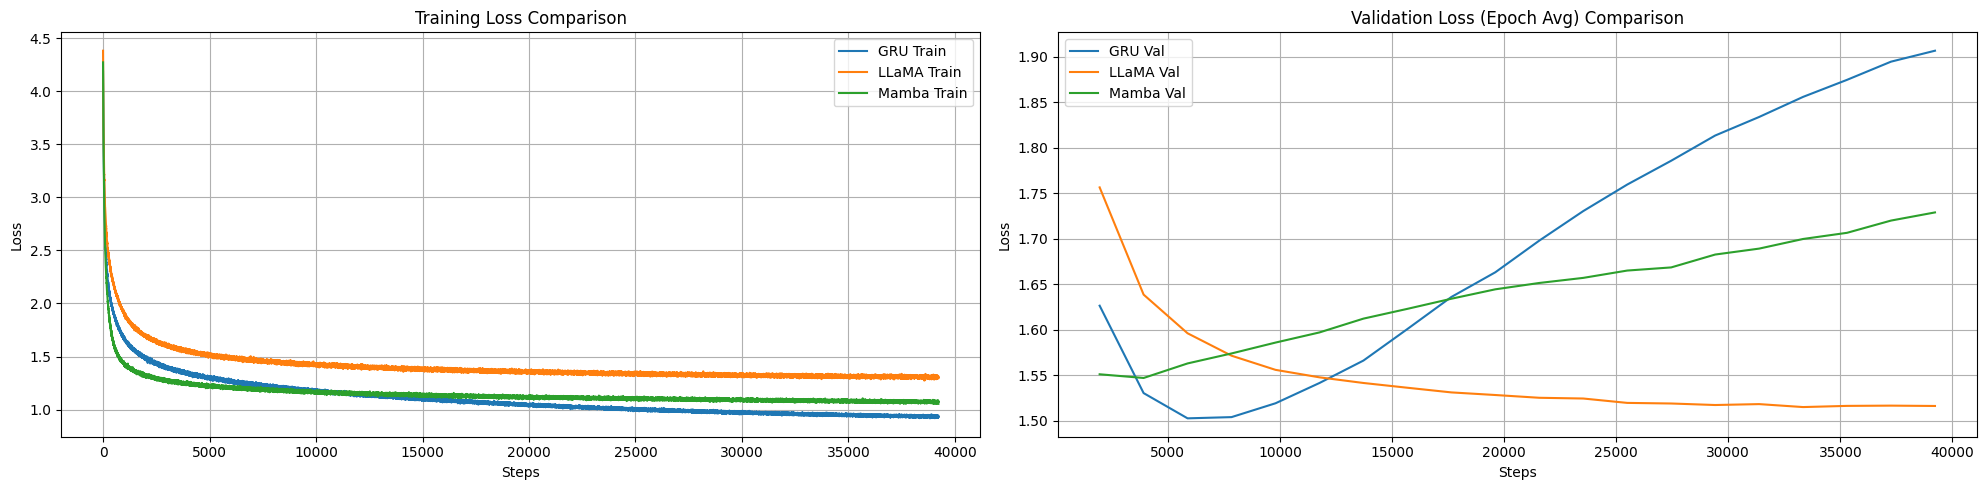

In [ ]:
train_and_test("Mamba", mamba, start_text)

## mingru

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math # math.log 및 상수 사용을 위함
from tqdm import tqdm # tqdm 임포트 추가

# Lion 옵티마이저 임포트 (설치 필요: pip install lion-pytorch)
# from lion_pytorch import Lion # 주석 처리 - 실제 사용 시 주석 해제

def log_g(x: torch.Tensor) -> torch.Tensor:
    """
    은닉 상태 후보를 로그 공간으로 변환하는 함수.
    x >= 0 이면 log(x + 0.5)
    x < 0 이면 log(sigmoid(x))
    """
    return torch.where(x >= 0, (F.relu(x) + 0.5).log(), -F.softplus(-x))

def parallel_scan_log(log_coeffs: torch.Tensor, log_values: torch.Tensor) -> torch.Tensor:
    """
    로그 공간에서 병렬 스캔 연산을 수행합니다. (클램핑 제거됨)
    Args:
        log_coeffs (torch.Tensor): [B, L, H_internal] 형태의 텐서로, log(alpha_t)를 나타냅니다.
        log_values (torch.Tensor): [B, L+1, H_internal] 형태의 텐서로, [log_h_initial, log(beta_1), ..., log(beta_L)]를 나타냅니다.
    Returns:
        torch.Tensor: [B, L, H_internal] 형태의 텐서로, 지수 함수가 적용된 은닉 상태 (h_1 부터 h_L까지)를 나타냅니다.
    """
    log_proda_coeffs_prefix = F.pad(torch.cumsum(log_coeffs, dim=1), (0, 0, 1, 0), value=0.0)
    terms_for_logcumsumexp = log_values - log_proda_coeffs_prefix
    log_sum_exp_terms = torch.logcumsumexp(terms_for_logcumsumexp, dim=1) 
    log_hidden_states = log_proda_coeffs_prefix + log_sum_exp_terms
    output_hidden_states = torch.exp(log_hidden_states[:, 1:, :]) 
    return output_hidden_states

class ParallelLogMinGRU(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, expansion_factor: float = 1.0, epsilon: float = 1e-7):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size 
        self.expansion_factor = expansion_factor # GRU 셀 내부의 확장 계수
        # GRU 셀 내부에서 사용될 확장된 차원 (hidden_size는 이 셀의 기본 출력 차원을 의미)
        self.internal_expanded_dim = int(hidden_size * self.expansion_factor)
        self.epsilon = epsilon

        # 입력 input_size를 internal_expanded_dim * 2 (은닉 상태 후보용, 게이트용)로 프로젝션
        self.to_hidden_and_gate = nn.Linear(input_size, self.internal_expanded_dim * 2)
        
        # GRU 셀 내부 확장이 있었다면, 다시 hidden_size로 프로젝션
        if self.expansion_factor != 1.0:
            self.to_out = nn.Linear(self.internal_expanded_dim, hidden_size)
        else:
            self.to_out = nn.Identity()
        self._init_weights()

    def _init_weights(self):
        for name, param in self.named_parameters():
            if 'linear' in name or 'to_hidden_and_gate' in name or 'to_out' in name :
                if 'weight' in name:
                    nn.init.xavier_uniform_(param)
                elif 'bias' in name and param is not None: # bias가 있을 경우에만 초기화
                    nn.init.zeros_(param)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: [B, L, input_size]
        B, L, _ = x.size()
        hidden_and_gate = self.to_hidden_and_gate(x) # [B, L, internal_expanded_dim * 2]
        h_candidate_input_expanded, logits_z_expanded = hidden_and_gate.chunk(2, dim=-1) # 각각 [B, L, internal_expanded_dim]
        
        log_A = F.logsigmoid(-logits_z_expanded)
        log_Z_expanded = F.logsigmoid(logits_z_expanded)
        log_h_candidate_contrib_expanded = log_g(h_candidate_input_expanded)
        log_B = log_Z_expanded + log_h_candidate_contrib_expanded

        log_h0_val = torch.full((B, 1, self.internal_expanded_dim),
                                math.log(self.epsilon),
                                device=x.device, dtype=x.dtype)
        log_vals = torch.cat([log_h0_val, log_B], dim=1) # [B, L+1, internal_expanded_dim]
        h_expanded_scan_out = parallel_scan_log(log_A, log_vals) # [B, L, internal_expanded_dim]
        
        output = self.to_out(h_expanded_scan_out) # [B, L, hidden_size]
        return output

class RMSNorm(nn.Module):
    def __init__(self, dim: int, eps: float = 1e-8):
        super().__init__()
        self.eps = eps
        self.gamma = nn.Parameter(torch.ones(dim))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        variance = x.pow(2).mean(dim=-1, keepdim=True)
        return x * torch.rsqrt(variance + self.eps) * self.gamma

class CausalDepthWiseConv1d(nn.Module):
    def __init__(self, dim: int, kernel_size: int):
        super().__init__()
        self.kernel_size = kernel_size
        self.net = nn.Sequential(
            nn.Conv1d(dim, dim, kernel_size=kernel_size, groups=dim), 
            nn.Conv1d(dim, dim, kernel_size=1)                       
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x_orig_shape = x.shape
        # x.ndim 대신 len(x.shape) 또는 x.dim() 사용
        if x.dim() == 2: 
            x = x.unsqueeze(0) 
        x_transposed = x.transpose(1, 2) 
        x_padded = F.pad(x_transposed, (self.kernel_size - 1, 0), value=0.)
        x_conv_out = self.net(x_padded)
        x_restored = x_conv_out.transpose(1, 2) 
        # len(x_orig_shape) 사용
        if len(x_orig_shape) == 2 and x_restored.shape[0] == 1:
            x_restored = x_restored.squeeze(0) 
        return x_restored

class SwiGLUFFN(nn.Module):
    def __init__(self, dim: int, expansion_factor: float = 4.0, dropout: float = 0.1):
        super().__init__()
        ffn_hidden_dim = int(dim * expansion_factor)
        
        self.w1_w3 = nn.Linear(dim, ffn_hidden_dim * 2, bias=False) 
        self.w2 = nn.Linear(ffn_hidden_dim, dim, bias=False)       
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x_proj = self.w1_w3(x)
        x1, x3_gate = x_proj.chunk(2, dim=-1) 
        hidden_states = F.silu(x1) * x3_gate
        hidden_states = self.dropout(hidden_states) 
        return self.w2(hidden_states)

class MinGRUDecoder(nn.Module):
    def __init__(
        self,
        vocab_size: int,
        embedding_dim: int,
        hidden_dim: int,
        num_layers: int = 2,
        dropout: float = 0.1, 
        expansion_factor_gru: float = 1.0, 
        epsilon_gru: float = 1e-7,
        rms_norm_eps: float = 1e-8,
        enable_conv: bool = True, 
        conv_kernel_size: int = 3, 
        ffn_expansion_factor: float = 1.0 
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.input_projection = nn.Linear(embedding_dim, hidden_dim) if embedding_dim != hidden_dim else nn.Identity()
        
        self.layers = nn.ModuleList()
        for _ in range(num_layers):
            ffn_layer = SwiGLUFFN(
                dim=hidden_dim, 
                expansion_factor=ffn_expansion_factor, 
                dropout=dropout 
            )

            self.layers.append(nn.ModuleList([
                CausalDepthWiseConv1d(hidden_dim, conv_kernel_size) if enable_conv else nn.Identity(), 
                RMSNorm(hidden_dim, eps=rms_norm_eps),                                                 
                ParallelLogMinGRU(
                    input_size=hidden_dim, 
                    hidden_size=hidden_dim, 
                    expansion_factor=expansion_factor_gru, 
                    epsilon=epsilon_gru
                ),                                                                                     
                RMSNorm(hidden_dim, eps=rms_norm_eps),                                                 
                ffn_layer,                                                                             
                nn.Dropout(dropout) if dropout > 0. else nn.Identity()                                 
            ]))

        self.final_norm = RMSNorm(hidden_dim, eps=rms_norm_eps) 
        self.output_fc1 = nn.Linear(hidden_dim, hidden_dim * 4) 
        self.output_fc2 = nn.Linear(hidden_dim * 4, vocab_size)
        self.final_dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor) -> tuple[torch.Tensor, None]:
        h = self.embedding(x)
        h = self.input_projection(h)

        for block_idx, block_modules in enumerate(self.layers):
            conv_layer, norm_gru_input, gru_cell, norm_ff_input, ffn_module, dropout_block_output = block_modules

            h_conv_input = h
            if not isinstance(conv_layer, nn.Identity): 
                h_conv_out = conv_layer(h)
                h = h_conv_input + h_conv_out 
            
            h_gru_residual_source = h
            h_normed_for_gru = norm_gru_input(h)
            h_gru_out = gru_cell(h_normed_for_gru)
            h = h_gru_residual_source + h_gru_out 

            h_ff_residual_source = h
            h_normed_for_ff = norm_ff_input(h)
            h_ff_out = ffn_module(h_normed_for_ff) 
            h = h_ff_residual_source + h_ff_out 
            
            h = dropout_block_output(h)
        
        h_norm_final = self.final_norm(h)
        h_dropped_final = self.final_dropout(h_norm_final) 
        
        output_expanded = F.gelu(self.output_fc1(h_dropped_final)) 
        logits = self.output_fc2(output_expanded)
        
        return logits, None

In [ ]:
### Model Initialization
mingru = MinGRUDecoder(vocab_size, EMBEDDING_DIM, int(HIDDEN_DIM*0.8), NUM_LAYERS).to(device)

In [ ]:
from torchinfo import summary

summary(mingru, input_size=(BATCH_SIZE, SEQUENCE_LENGTH), dtypes=[torch.long])

Layer (type:depth-idx)                        Output Shape              Param #
MinGRUDecoder                                 [512, 128, 65]            --
├─Embedding: 1-1                              [512, 128, 128]           8,320
├─Linear: 1-2                                 [512, 128, 204]           26,316
├─ModuleList: 1-3                             --                        --
│    └─ModuleList: 2-1                        --                        --
│    │    └─CausalDepthWiseConv1d: 3-1        [512, 128, 204]           42,636
│    │    └─RMSNorm: 3-2                      [512, 128, 204]           204
│    │    └─ParallelLogMinGRU: 3-3            [512, 128, 204]           83,640
│    │    └─RMSNorm: 3-4                      [512, 128, 204]           204
│    │    └─SwiGLUFFN: 3-5                    [512, 128, 204]           124,848
│    │    └─Dropout: 3-6                      [512, 128, 204]           --
│    └─ModuleList: 2-2                        --                        -

Epoch 1/20, Train Loss: 1.4677, Val Loss: 1.7315, Epoch Time: 75.28s Average Vram Usage: 2485.44MB


Epoch 2/20, Train Loss: 1.3767, Val Loss: 1.7256, Epoch Time: 75.77s Average Vram Usage: 2485.44MB


Epoch 3/20, Train Loss: 1.3095, Val Loss: 1.7232, Epoch Time: 75.13s Average Vram Usage: 2485.44MB


Epoch 4/20, Train Loss: 1.2822, Val Loss: 1.7287, Epoch Time: 75.14s Average Vram Usage: 2485.44MB


Epoch 5/20, Train Loss: 1.2435, Val Loss: 1.7421, Epoch Time: 75.04s Average Vram Usage: 2485.44MB


Epoch 6/20, Train Loss: 1.2443, Val Loss: 1.7507, Epoch Time: 75.45s Average Vram Usage: 2485.44MB


Epoch 7/20, Train Loss: 1.2150, Val Loss: 1.7497, Epoch Time: 75.16s Average Vram Usage: 2485.44MB


Epoch 8/20, Train Loss: 1.2011, Val Loss: 1.7566, Epoch Time: 75.56s Average Vram Usage: 2485.44MB


Epoch 9/20, Train Loss: 1.1916, Val Loss: 1.7626, Epoch Time: 75.29s Average Vram Usage: 2485.44MB


Epoch 10/20, Train Loss: 1.1693, Val Loss: 1.7633, Epoch Time: 74.86s Average Vram Usage: 2485.44MB


Epoch 11/20, Train Loss: 1.1810, Val Loss: 1.7573, Epoch Time: 74.69s Average Vram Usage: 2485.44MB


Epoch 12/20, Train Loss: 1.1638, Val Loss: 1.7514, Epoch Time: 75.30s Average Vram Usage: 2485.44MB


Epoch 13/20, Train Loss: 1.1580, Val Loss: 1.7578, Epoch Time: 75.14s Average Vram Usage: 2485.44MB


Epoch 14/20, Train Loss: 1.1489, Val Loss: 1.7518, Epoch Time: 75.64s Average Vram Usage: 2485.44MB


Epoch 15/20, Train Loss: 1.1275, Val Loss: 1.7578, Epoch Time: 75.15s Average Vram Usage: 2485.44MB


Epoch 16/20, Train Loss: 1.1428, Val Loss: 1.7741, Epoch Time: 75.50s Average Vram Usage: 2485.44MB


Epoch 17/20, Train Loss: 1.1326, Val Loss: 1.7914, Epoch Time: 75.31s Average Vram Usage: 2485.44MB


Epoch 18/20, Train Loss: 1.1286, Val Loss: 1.7630, Epoch Time: 75.14s Average Vram Usage: 2485.44MB


Epoch 19/20, Train Loss: 1.1087, Val Loss: 1.7780, Epoch Time: 75.11s Average Vram Usage: 2485.44MB


Epoch 20/20, Train Loss: 1.1265, Val Loss: 1.7623, Epoch Time: 74.75s Average Vram Usage: 2485.44MB
Generated text [

GREMIO:
Good morrow, neighbour Baptista.

BAPTISTA:
Good morrow, neighbour Gremio.
God save you, gentlemen!

PETRUCHIO:
And yo]:
--------------------------------------------------


GREMIO:
Good morrow, neighbour Baptista.

BAPTISTA:
Good morrow, neighbour Gremio.
God save you, gentlemen!

PETRUCHIO:
And you shall not: how it consents before,
Though my help--or, boy, Mercutio!
My Lord of York would be in Rome all return?
On me, ten till for such victory: or are other
confirm'd; but that we will lead me of not, pleasing you?
'Tis past one for that when King Edward spurs;
For only I'll give you have no day; and he has,
And never show your queen's to fear; who, once more.
Welcome, Bushy, Green. Did I above I
An even with the county thousand dub give us,
And makes more weighing to her.

POLIXENES:
Suc


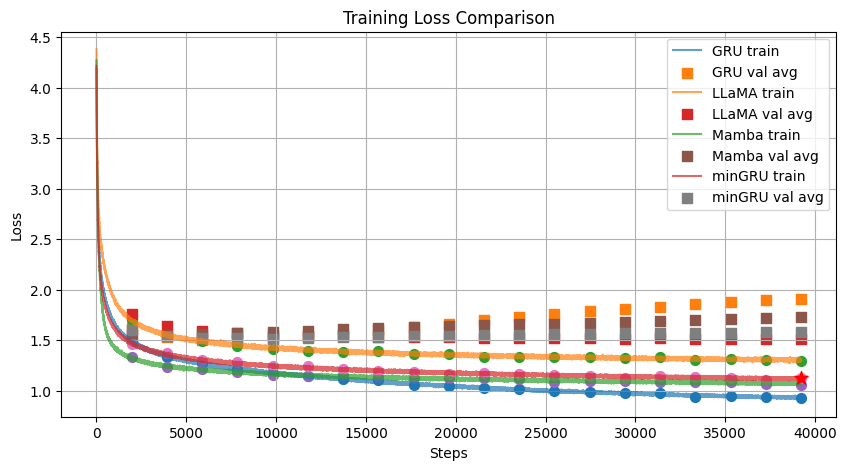

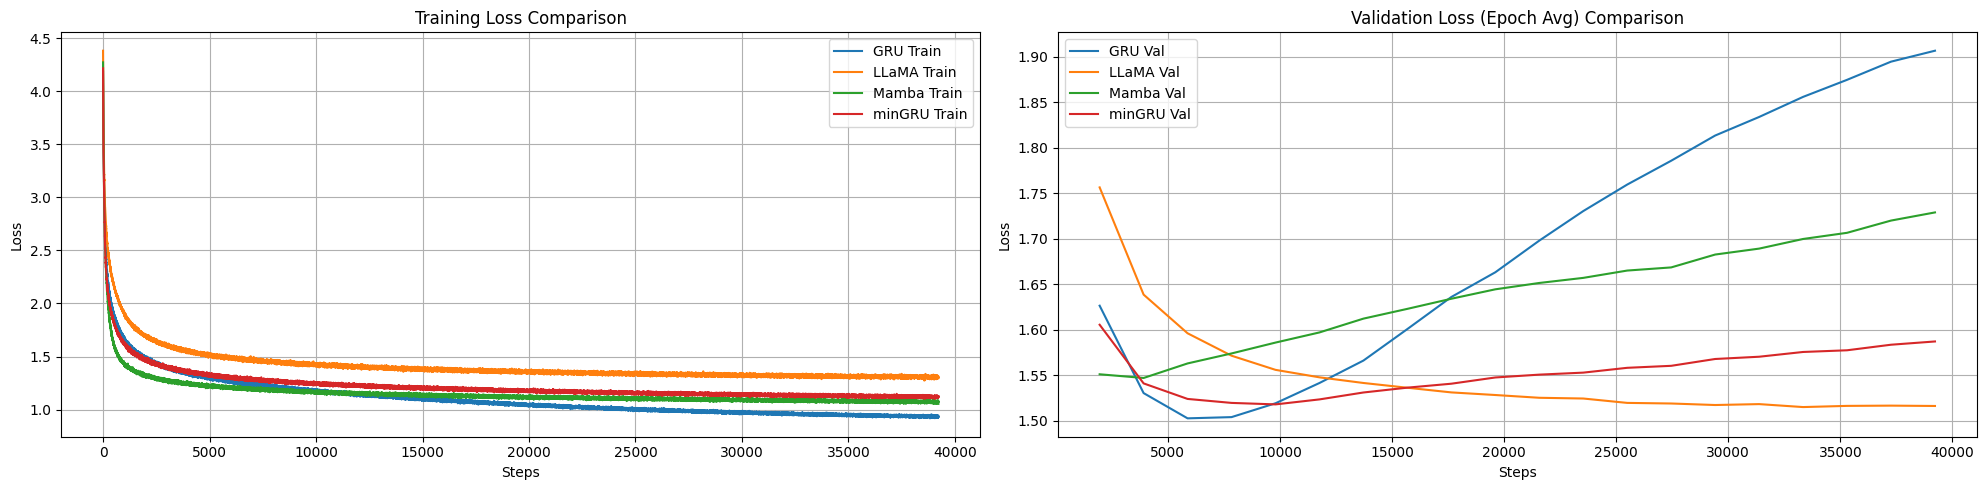

In [ ]:
train_and_test("minGRU", mingru, start_text)

In [ ]:
import io

def count_params(m): return sum(p.numel() for p in m.parameters())
def model_size_kb(m):
    buf=io.BytesIO(); torch.save(m.state_dict(),buf)
    return round(len(buf.getvalue())/1024)
def measure_time_ms(m,inp,iters=20):
    m.eval()
    with torch.no_grad():
        for _ in range(5): m(inp)
        ts=[]
        for _ in range(iters):
            t0=time.time(); m(inp); ts.append((time.time()-t0)*1000)
    return sum(ts)/len(ts)


models={
    "Transformer":llama,
    "Mamba": mamba,
    "GRU": gru,
    "MinGRU": mingru
}

# 1) fixed length
inputs=torch.randint(vocab_size,(BATCH_SIZE,SEQUENCE_LENGTH),dtype=torch.long,device=device)
records=[]
for name,m in models.items():
    records.append({
        "Model": name,
        "Params": count_params(m),
        "Size_KB": model_size_kb(m),
        "Time_512_ms": round(measure_time_ms(m,inputs), 2)
    })
df_fixed=pd.DataFrame(records).set_index("Model")

# 2) speed vs length
seq_lens=[128,256,512,768,1024]
speed_data={name:[round(measure_time_ms(m,torch.randint(vocab_size,(BATCH_SIZE,L),dtype=torch.long,device=device)), 2) for L in seq_lens]
            for name,m in models.items()}
df_speed=pd.DataFrame(speed_data,index=seq_lens)
df_speed.index.name="Seq_Len"


In [ ]:
print("=== Comparison ===")
display(df_fixed)

=== Comparison ===


,Params,Size_KB,Time_512_ms
Model,,,
Transformer,541632,2124,10.62
Mamba,667904,2616,2.96
GRU,782529,3060,4.46
MinGRU,758289,2971,9.76


In [ ]:
display(df_speed)

,Transformer,Mamba,GRU,MinGRU
Seq_Len,,,,
128,10.69,8.29,4.99,10.85
256,25.35,14.54,10.07,23.46
512,70.60,29.22,19.39,46.32
768,137.55,53.26,28.34,72.74
1024,226.14,79.53,37.35,98.89


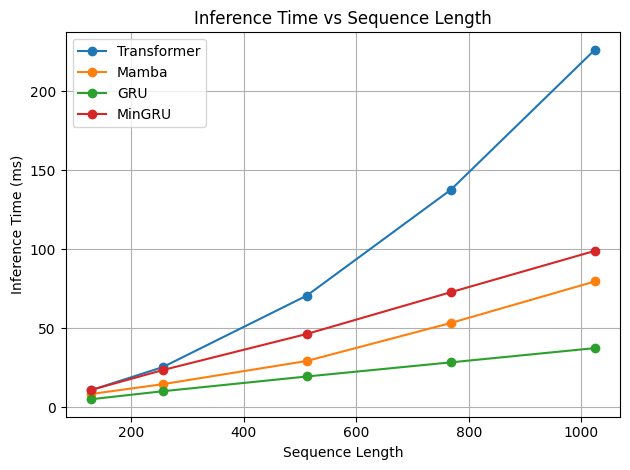

In [ ]:
import matplotlib.pyplot as plt

# df_speed: DataFrame with index=sequence lengths and columns=model names, values=time in ms
plt.figure()
for model in df_speed.columns:
    plt.plot(df_speed.index, df_speed[model], marker='o', label=model)
plt.xlabel("Sequence Length")
plt.ylabel("Inference Time (ms)")
plt.title("Inference Time vs Sequence Length")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
